# Visualizing the weather!

1. Read Randal Olson's [article](http://fivethirtyeight.com/features/what-12-months-of-record-setting-temperatures-looks-like-across-the-u-s/) on 538.
2. Read his blog about [making the plots](http://www.randalolson.com/2015/08/13/the-new-york-times-weather-chart-redux/)

Now check out the code below. You're **NOT** expected to understand, read and write Python code for this course! We will be tweaking it a bit to do what you want, though!

**Instructor note: everybody runs everything through the scraping right now, so it can scrape while we're talking.**

In [23]:
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Grabbing the data

First, we need to grab the data from Wunderground. You can find historical data on pages like [this](http://www.wunderground.com/history/airport/KVES/2015/10/14/DailyHistory.html?req_city=Richmond&req_state=IN&reqdb.zip=47374&reqdb.magic=1&reqdb.wmo=99999).

Looking through each of those and writing down all of the values would be a *giant* pain. So, we do what's called "web scraping" to automate the process. It looks like this:

In [24]:
def scrape_station(station):
    '''
    This function scrapes the weather data web pages from wunderground.com
    for the station you provide it.
    You can look up your city's weather station by performing a search for
    it on wunderground.com then clicking on the "History" section.
    The 4-letter name of the station will appear on that page.
    '''

    # Scrape between July 1, 2014 and July 1, 2015
    # You can change the dates here if you prefer to scrape a different range
    current_date = datetime(year=2014, month=7, day=1)
    end_date = datetime(year=2015, month=7, day=1)

    # Make sure a directory exists for the station web pages
    os.mkdir(station)

    # Use .format(station, YYYY, M, D)
    lookup_URL = 'http://www.wunderground.com/history/airport/{}/{}/{}/{}/DailyHistory.html'

    while current_date != end_date:

        if current_date.day == 1:
            print(current_date)

        formatted_lookup_URL = lookup_URL.format(station,
                                                 current_date.year,
                                                 current_date.month,
                                                 current_date.day)
        html = urlopen(formatted_lookup_URL).read().decode('utf-8')

        out_file_name = '{}/{}-{}-{}.html'.format(station, current_date.year,
                                                  current_date.month,
                                                  current_date.day)

        with open(out_file_name, 'w') as out_file:
            out_file.write(html)

        current_date += timedelta(days=1)

### Grabbing Richmond's data

We could then grab Richmond's data with the following:

In [ ]:
scrape_station('KVES')

## Parsing

That grabs the raw web pages.

We then need to make sense of the above information.

In [25]:
def parse_station(station):
    '''
    This function parses the web pages downloaded from wunderground.com
    into a flat CSV file for the station you provide it.

    Make sure to run the wunderground scraper first so you have the web
    pages downloaded.
    '''

    # Scrape between July 1, 2014 and July 1, 2015
    # You can change the dates here if you prefer to parse a different range
    current_date = datetime(year=2014, month=7, day=1)
    end_date = datetime(year=2015, month=7, day=1)

    with open('{}.csv'.format(station), 'w') as out_file:
        out_file.write('date,actual_mean_temp,actual_min_temp,actual_max_temp,'
                       'average_min_temp,average_max_temp,'
                       'record_min_temp,record_max_temp,'
                       'record_min_temp_year,record_max_temp_year,'
                       'actual_precipitation,average_precipitation,'
                       'record_precipitation\n')

        while current_date != end_date:
            try_again = False
            with open('{}/{}-{}-{}.html'.format(station,
                                                current_date.year,
                                                current_date.month,
                                                current_date.day)) as in_file:
                soup = BeautifulSoup(in_file.read(), 'html.parser')

                weather_data = soup.find(id='historyTable').find_all('span', class_='wx-value')
                weather_data_units = soup.find(id='historyTable').find_all('td')

                try:
                    actual_mean_temp = weather_data[0].text
                    actual_max_temp = weather_data[2].text
                    average_max_temp = weather_data[3].text
                    record_max_temp = weather_data[4].text
                    actual_min_temp = weather_data[5].text
                    average_min_temp = weather_data[6].text
                    record_min_temp = weather_data[7].text
                    record_max_temp_year = weather_data_units[
                        9].text.split('(')[-1].strip(')')
                    record_min_temp_year = weather_data_units[
                        13].text.split('(')[-1].strip(')')

                    actual_precipitation = weather_data[9].text
                    if actual_precipitation == 'T':
                        actual_precipitation = '0.0'
                    average_precipitation = weather_data[10].text
                    record_precipitation = weather_data[11].text

                    # Verify that the parsed data is valid
                    if (record_max_temp_year == '-1' or record_min_temp_year == '-1' or
                            int(record_max_temp) < max(int(actual_max_temp), int(average_max_temp)) or
                            int(record_min_temp) > min(int(actual_min_temp), int(average_min_temp)) or
                            float(actual_precipitation) > float(record_precipitation) or
                            float(average_precipitation) > float(record_precipitation)):
                        raise Exception

                    out_file.write('{}-{}-{},'.format(current_date.year, current_date.month, current_date.day))
                    out_file.write(','.join([actual_mean_temp, actual_min_temp, actual_max_temp,
                                             average_min_temp, average_max_temp,
                                             record_min_temp, record_max_temp,
                                             record_min_temp_year, record_max_temp_year,
                                             actual_precipitation, average_precipitation,
                                             record_precipitation]))
                    out_file.write('\n')
                    current_date += timedelta(days=1)
                except:
                    # If the web page is formatted improperly, signal that the page may need
                    # to be downloaded again.
                    try_again = True

            # If the web page needs to be downloaded again, re-download it from
            # wunderground.com

            # If the parser gets stuck on a certain date, you may need to investigate
            # the page to find out what is going on. Sometimes data is missing, in
            # which case the parser will get stuck. You can manually put in the data
            # yourself in that case, or just tell the parser to skip this day.
            if try_again:
                
                print('Error with date {}'.format(current_date))
                
                actual_mean_temp = '0.0'
                actual_max_temp = '0.0'
                average_max_temp = '0.0'
                record_max_temp = '0.0'
                actual_min_temp = '0.0'
                average_min_temp = '0.0'
                record_min_temp = '0.0'
                record_max_temp_year = '0.0'
                record_min_temp_year = '0.0'

                actual_precipitation = '0.0'
                average_precipitation = '0.0'
                record_precipitation = '0.0'

                out_file.write('{}-{}-{},'.format(current_date.year, current_date.month, current_date.day))
                out_file.write(','.join([actual_mean_temp, actual_min_temp, actual_max_temp,
                                         average_min_temp, average_max_temp,
                                         record_min_temp, record_max_temp,
                                         record_min_temp_year, record_max_temp_year,
                                         actual_precipitation, average_precipitation,
                                         record_precipitation]))
                out_file.write('\n')
                current_date += timedelta(days=1)

In [ ]:
parse_station('KVES')

## Visualize!

Now let's make some pretty plots!

In [36]:
def visualize_station(station):
    weather_data = pd.read_csv(station+'.csv', parse_dates=['date'])
    print(weather_data.describe())

    # Generate a bunch of histograms of the data to make sure that all of the data
    # is in an expected range.

    '''
    I also use a custom matplotlib style as the basis for these charts, which you
    can find here: https://gist.githubusercontent.com/rhiever/d0a7332fe0beebfdc3d5/raw/223d70799b48131d5ce2723cd5784f39d7a3a653/tableau10.mplstyle
    '''

    with plt.style.context('https://gist.githubusercontent.com/rhiever/d0a7332fe0beebfdc3d5/raw/223d70799b48131d5ce2723cd5784f39d7a3a653/tableau10.mplstyle'):
        for column in weather_data.columns:
            if column in ['date']:
                continue
            plt.figure()
            plt.hist(weather_data[column].values)
            plt.title(column)
            plt.savefig('{}.png'.format(column))

        # Make sure we're only plotting temperatures for July 2014 - June 2015
        weather_data_subset = weather_data[weather_data['date'] >= datetime(year=2014, month=7, day=1)]
        weather_data_subset = weather_data_subset[weather_data_subset['date'] < datetime(year=2015, month=6, day=30)].copy()
        weather_data_subset['day_order'] = range(len(weather_data_subset))

        day_order = weather_data_subset['day_order']
        record_max_temps = weather_data_subset['record_max_temp'].values
        record_min_temps = weather_data_subset['record_min_temp'].values
        average_max_temps = weather_data_subset['average_max_temp'].values
        average_min_temps = weather_data_subset['average_min_temp'].values
        actual_max_temps = weather_data_subset['actual_max_temp'].values
        actual_min_temps = weather_data_subset['actual_min_temp'].values

        fig, ax1 = plt.subplots(figsize=(15, 7))

        # Create the bars showing all-time record highs and lows
        plt.bar(day_order, record_max_temps - record_min_temps, bottom=record_min_temps,
                edgecolor='none', color='#C3BBA4', width=1)

        # Create the bars showing average highs and lows
        plt.bar(day_order, average_max_temps - average_min_temps, bottom=average_min_temps,
                edgecolor='none', color='#9A9180', width=1)

        # Create the bars showing this year's highs and lows
        plt.bar(day_order, actual_max_temps - actual_min_temps, bottom=actual_min_temps,
                edgecolor='black', linewidth=0.5, color='#5A3B49', width=1)

        new_max_records = weather_data_subset[weather_data_subset.record_max_temp <= weather_data_subset.actual_max_temp]
        new_min_records = weather_data_subset[weather_data_subset.record_min_temp >= weather_data_subset.actual_min_temp]
        
        circle_size= 40
        horizontal_offset = 0.6
#        horizontal_offset = 0.75
        vertical_offset = 1.25
        vertical_offset = 4.0

        # Create the dots marking record highs and lows for the year
        plt.scatter(new_max_records['day_order'].values + horizontal_offset,
                    new_max_records['actual_max_temp'].values + vertical_offset,
                    s=circle_size, zorder=10, color='#d62728', alpha=0.75, linewidth=0)

        plt.scatter(new_min_records['day_order'].values + horizontal_offset,
                    new_min_records['actual_min_temp'].values - vertical_offset,
                    s=circle_size, zorder=10, color='#1f77b4', alpha=0.75, linewidth=0)

        plt.ylim(-50, 141)
        plt.xlim(-5, 370)

        plt.yticks(range(-50, 141, 10), [r'{}$^\circ$'.format(x)
                                         for x in range(-50, 141, 10)], fontsize=10)
        plt.ylabel(r'Temperature ($^\circ$F)', fontsize=12)

        month_beginning_df = weather_data_subset[weather_data_subset['date'].apply(lambda x: True if x.day == 1 else False)]
        month_beginning_indeces = list(month_beginning_df['day_order'].values)
        month_beginning_names = list(month_beginning_df['date'].apply(lambda x: x.strftime("%B")).values)
        month_beginning_names[0] += '\n\'14'
        month_beginning_names[6] += '\n\'15'

        # Add the last month label manually
        month_beginning_indeces += [weather_data_subset['day_order'].values[-1]]
        month_beginning_names += ['July']

        plt.xticks(month_beginning_indeces,
                   month_beginning_names,
                   fontsize=10)

        ax2 = ax1.twiny()
        plt.xticks(month_beginning_indeces,
                   month_beginning_names,
                   fontsize=10)

        plt.xlim(-5, 370)
        plt.grid(False)

        ax3 = ax1.twinx()
        plt.yticks(range(-50, 141, 10), [r'{}$^\circ$'.format(x)
                                         for x in range(-50, 141, 10)], fontsize=10)
        plt.ylim(-50, 141)
        plt.grid(False)

        plt.title(station+'\'s weather, July 2014 - June 2015\n\n', fontsize=20)

        plt.savefig(station+'-weather-july14-june15.png')
        plt.show()

       actual_mean_temp  actual_min_temp  actual_max_temp  average_min_temp  \
count        365.000000       365.000000       365.000000        365.000000   
mean          48.610959        39.435616        57.676712         42.802740   
std           19.370502        18.624967        20.858620         15.829431   
min            2.000000        -7.000000         8.000000         19.000000   
25%           34.000000        26.000000        41.000000         28.000000   
50%           50.000000        41.000000        60.000000         43.000000   
75%           65.000000        55.000000        78.000000         59.000000   
max           78.000000        70.000000        89.000000         65.000000   

       average_max_temp  record_min_temp  record_max_temp  \
count        365.000000       365.000000       365.000000   
mean          61.106849        20.849315        83.380822   
std           17.743505        21.887369        14.353472   
min           34.000000       -28.000000    

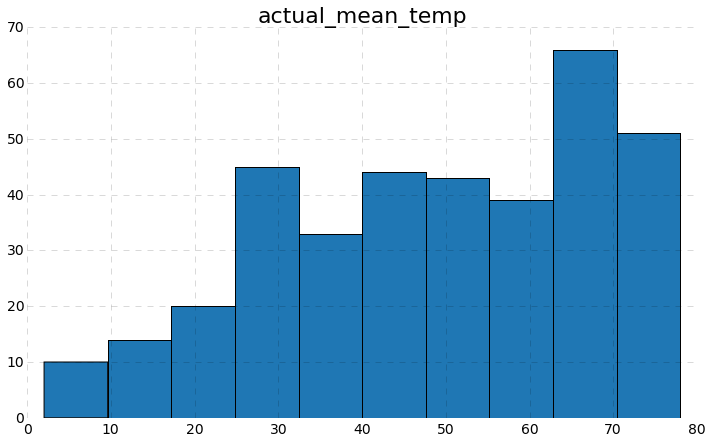

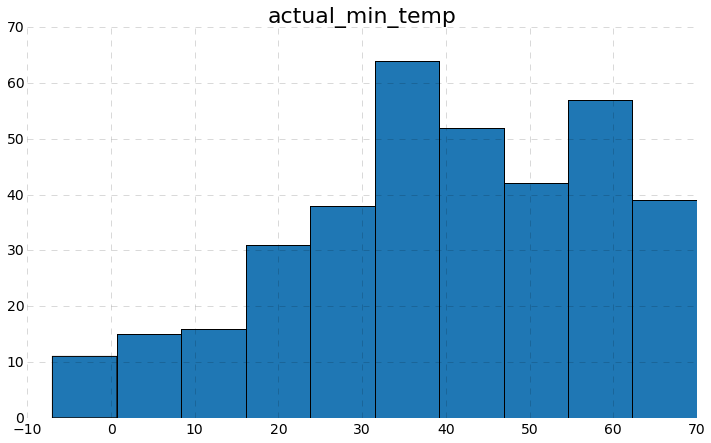

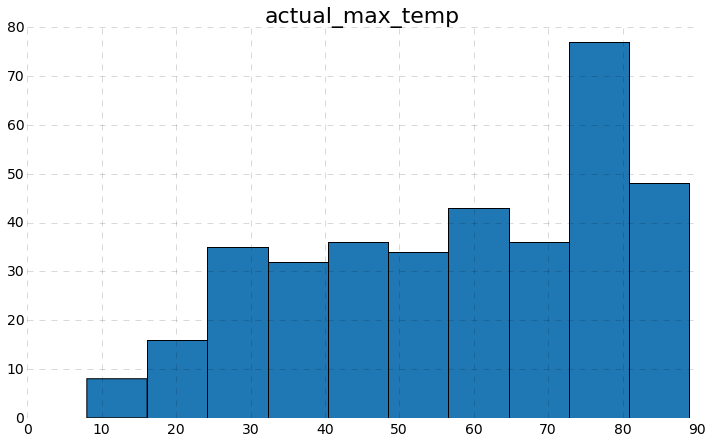

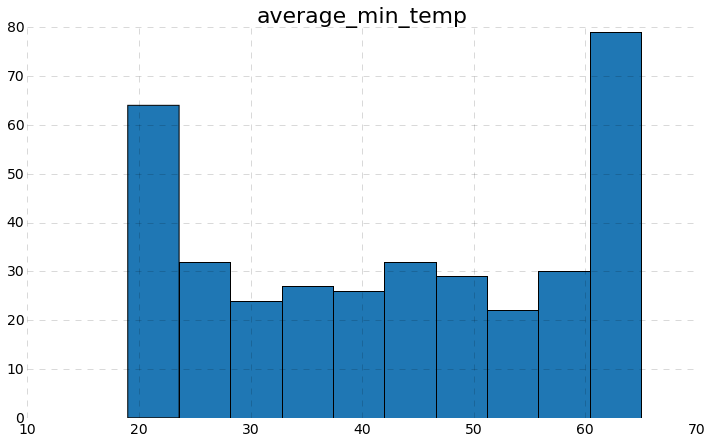

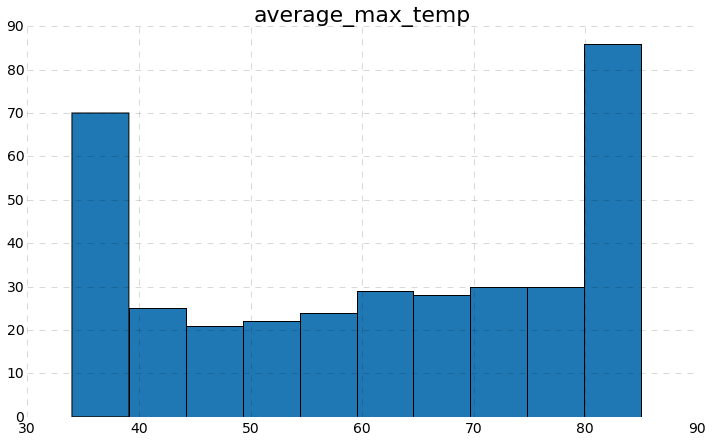

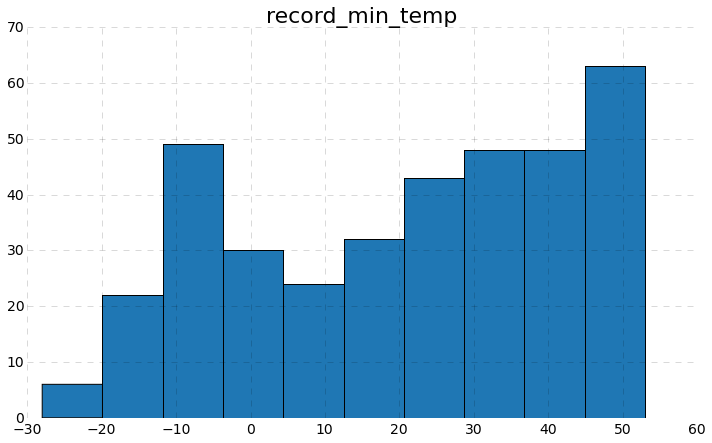

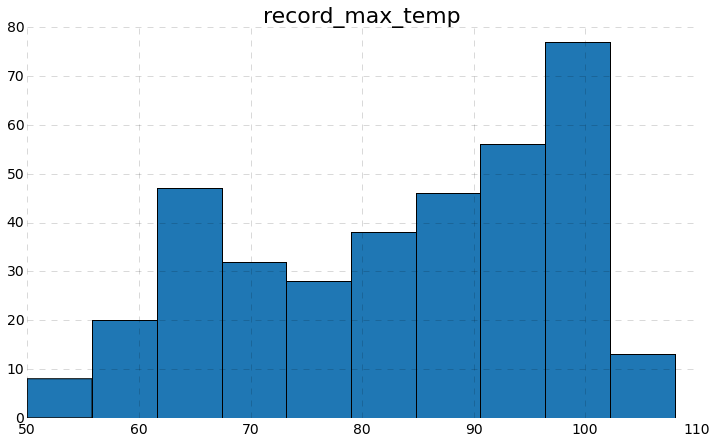

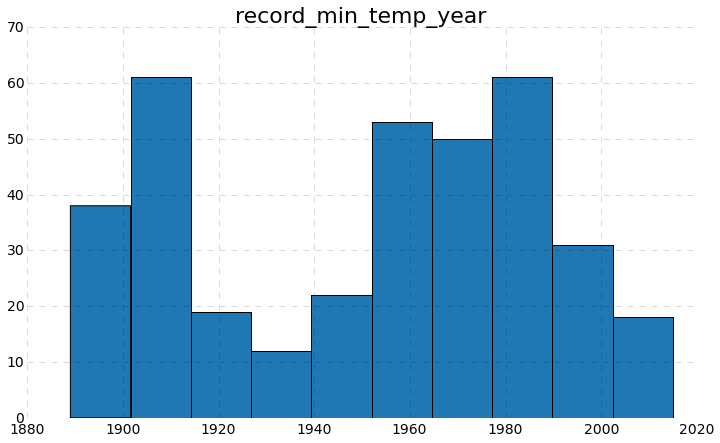

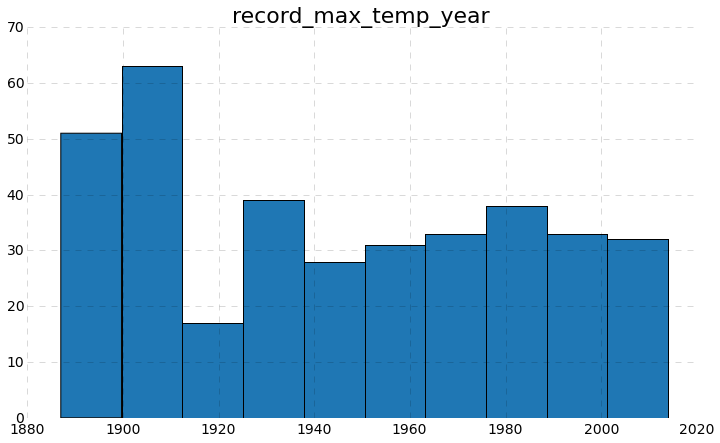

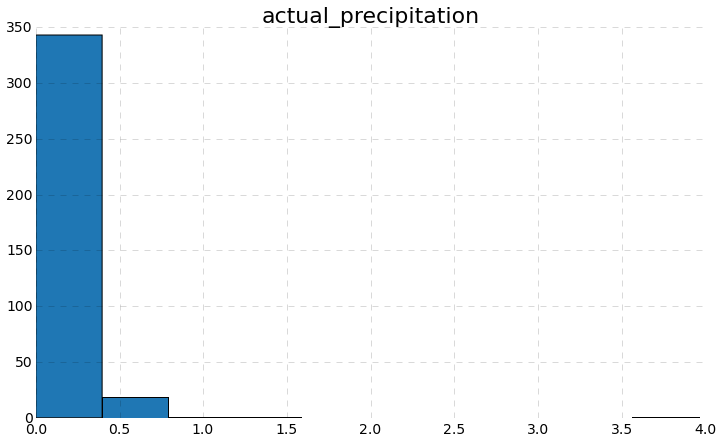

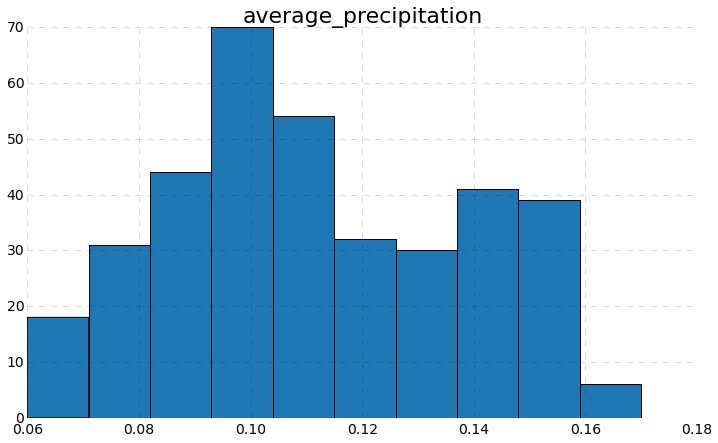

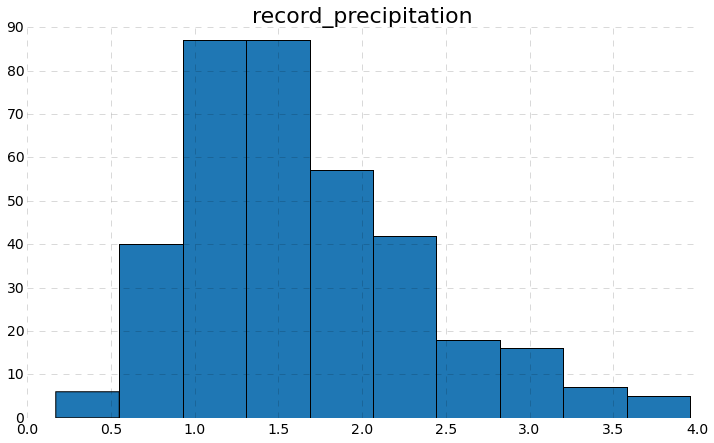

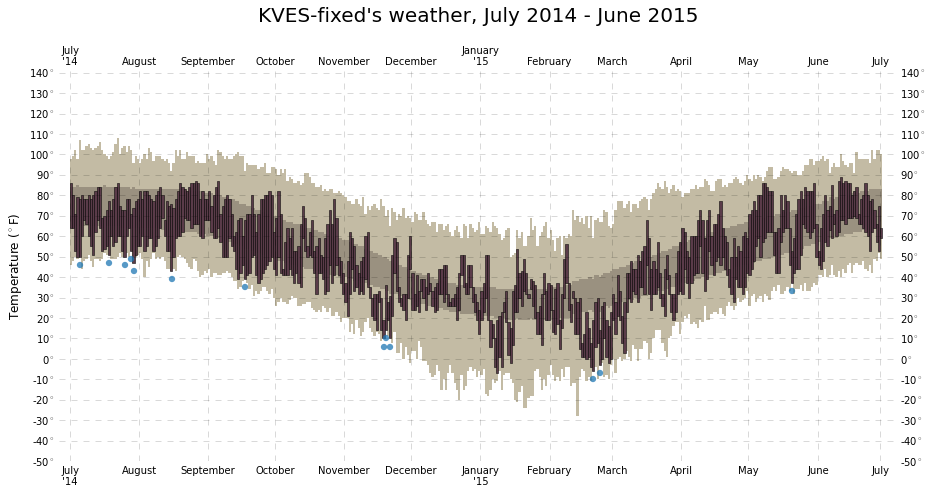

In [37]:
visualize_station('KVES-fixed')